In [105]:
import time
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [272]:
import enum
class InfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21,
                 recovery_sd=7):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = np.random.randint(self.grid.width)
            y = np.random.randint(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.9,0.1])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state",
                            'Infector':'infector'})

    def get_recovery_time(self):
        return int(np.random.normal(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [278]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = np.random.normal(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0
        self.infector = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = np.random.choice(len(possible_steps))
        new_position = possible_steps[new_position]
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""

        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
                
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if np.random.uniform() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infector = self.unique_id
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

In [313]:
model = InfectionModel(N=1000,death_rate=.02,ptrans=1)
steps=10000
for i in range(steps):
    model.step()
agent_state = model.datacollector.get_agent_vars_dataframe()

In [314]:
agent_state

State  Infector
Step AgentID                 
0    0            0         0
     1            0         0
     2            0         0
     3            1         0
     4            0         0
...             ...       ...
327  206          1       591
     757          1       821
328  206          1       591
329  206          1       591
330  206          1       591

[50231 rows x 2 columns]

In [315]:
agent_state = agent_state.reset_index()
SI=[]
for agent_id in range(1000):
    tmp_infector = agent_state.loc[agent_state["AgentID"] == agent_id]["Infector"].values[-1]
    infector_df = agent_state.loc[agent_state["AgentID"] == tmp_infector]["State"].values
    if np.any(infector_df>0):
        infector_time = np.where(infector_df==1)[0][0]
        infectee_time = np.where(agent_state.loc[agent_state["AgentID"] == agent_id]["State"].values==1)[0][0]
        SI =SI+[ infectee_time - infector_time]

IndexError: index 0 is out of bounds for axis 0 with size 0

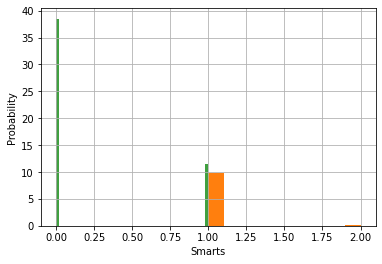

0.23015873015873015
1.019


In [316]:
SI_pos = [item for item in SI if item >= 0]
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(SI_pos, 50, density=True, facecolor='g', alpha=0.75)
geom_sim = np.random.geometric(.98,1000)
plt.hist(geom_sim,density=True)

plt.xlabel('Smarts')
plt.ylabel('Probability')

plt.grid(True)
plt.show()
print (np.mean(SI_pos))
print (np.mean(geom_sim))

In [235]:
plot_states_bokeh(model)

ValueError: Length mismatch: Expected axis has 6 elements, new values have 3 elements